In [1]:
import numpy as np
import random
import time
import math
import random
import os
import sys
from datetime import datetime

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety

# Original

In [96]:
###
# Clase original
###

###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self,id_ud, media):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None]* (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear): #metodo para buscar e reproducir.
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filho_disponivel, posição_filho, idade_filho = filho_e_idade(self, 1) #Se a unidade tem um filho homem disponivel para procurar esposa
        if filho_disponivel:
            
            #Filtro para escolher outra UD para criar uma nova UD
            #Parentes disponivels: 
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                    ud.activa == True and #Que a UD esteja viva.
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, self.parentes[0:5] + self.parentes[7:9]) and # Que a UD não seja um parent
                    filho_e_idade(ud,0)[0] and #Que tenha uma filha
                    abs(filho_e_idade(ud,0)[2] - idade_filho) <= 13] #Que a diferença entre as idades não seja maior a 10
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                    not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes[0:5] + self.uds[id_ud].parentes[7:9])] #QUe a UD não seja um parente
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                filha_disponivel, posição_filha, idade_filha = filho_e_idade(UD.uds[cassal_id], 0)
                #print(filha_disponivel, posição_filha, idade_filha)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1 
                novo_nodo = UD(novo_id, media)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filho)
                self.uds[cassal_id].filhos.pop(posição_filha)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
        if random.random() < 0.001:
            # uma aleatoria
            variedad_a_mutar = random.choice(vari_mae + vari_pai)
            # mutacao
            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

# With comunity

In [2]:
## Class with rule of marriage of community: Only with different community
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self, id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear, locality): #metodo para buscar e reproducir.
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filho_disponivel, posição_filho, idade_filho = filho_e_idade(self, 0) #Se a unidade tem uma filha (mulher) disponivel para procurar esposa
        if filho_disponivel:
            
            #Filtro para escolher outra UD para criar uma nova UD
            #Parentes disponivels: 
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                    ud.activa == True and #Que a UD esteja viva.
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, self.parentes[0:5] + self.parentes[7:9]) and # Que a UD não seja um parent
                    filho_e_idade(ud,1)[0] and #Que tenha um filho
                    abs(filho_e_idade(ud,0)[2] - idade_filho) <= 13 and #Que a diferença entre as idades não seja maior a 10
                    ud.community != self.community] #From a different community 
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                    not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes[0:5] + self.uds[id_ud].parentes[7:9])] #QUe a UD não seja um parente
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                filha_disponivel, posição_filha, idade_filha = filho_e_idade(UD.uds[cassal_id], 1)
                #print(filha_disponivel, posição_filha, idade_filha)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filho)
                self.uds[cassal_id].filhos.pop(posição_filha)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
        if random.random() < 0.001:
            # uma aleatoria
            variedad_a_mutar = random.choice(vari_mae + vari_pai)
            # mutacao
            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

# With community and less restrictive kinship rules (In other words, UDs cannot look for couples for their daughters only in their parents, grand parents, children and gran children) 
This particular Class is used to set a limit in the number of UD on the model
0,1,2,3,7

In [10]:
## Class with rule of marriage of community: Only with different community
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self, id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear, locality): #metodo para buscar e reproducir.
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filha_disponivel, posição_filha, idade_filha = filho_e_idade(self, 0) #Se a unidade tem uma filha disponivel para procurar esposa
        if filha_disponivel:
            
            #Filtro para escolher outra UD para criar uma nova UD
            #Parentes disponivels: 
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                    ud.activa == True and #Que a UD esteja viva.
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, [self.parentes[i] for i in [0, 1, 2, 3, 7]]) and # Que a UD não seja um parent
                    filho_e_idade(ud,1)[0] and #Que tenha um filho
                    abs(filho_e_idade(ud,1)[2] - idade_filha) <= 13 and #Que a diferença entre as idades não seja maior a 10
                    ud.community != self.community] #From a different community 
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                    not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes[0:5] + self.uds[id_ud].parentes[7:9])] #QUe a UD não seja um parente
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                filho_disponivel, posição_filho, idade_filho = filho_e_idade(UD.uds[cassal_id], 1)
                #print(filho_disponivel, posição_filho, idade_filho)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filha)
                self.uds[cassal_id].filhos.pop(posição_filho)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
        if random.random() < 0.001:
            # uma aleatoria
            variedad_a_mutar = random.choice(vari_mae + vari_pai)
            # mutacao
            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

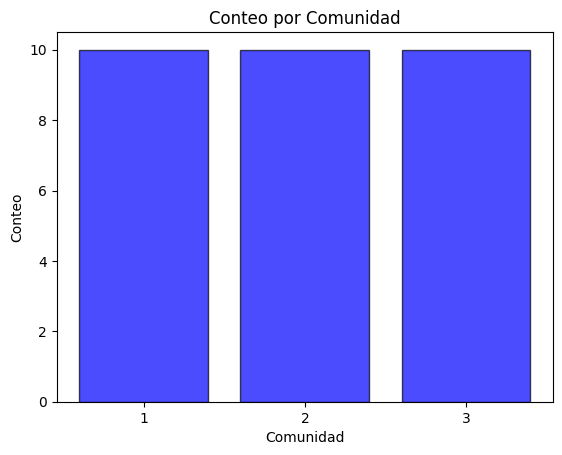

tamos en tiempo 100 con vivas 122
3
tamos en tiempo 200 con vivas 299
tamos en tiempo 300 con vivas 207
5
tamos en tiempo 400 con vivas 156
3
tamos en tiempo 500 con vivas 308
tamos en tiempo 600 con vivas 189
5
tamos en tiempo 700 con vivas 161
3
tamos en tiempo 800 con vivas 225
tamos en tiempo 900 con vivas 173
5
3
251


In [12]:
#### Parameters for simulation
iniciais = 30 # Initial UD
prob_morte = 0.05 # Beta from the gutertz equation
media = 5 # Average children per UD
random.seed(42) # Random seed
t = 1000 #steps of the simulation
UD.uds = {}

#### Initialization
## Comunidades
UD.uds = {}
comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
instancias_ud = []
for id_ud in range(1, int(iniciais) + 1):
    instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
## Variedades y repartirlas entre las comunidades
for id_ud, ud in UD.uds.items():
    for _ in range(5):
        ud.varieties.append(Variety())

comunidades_lista = [ud.community for ud in UD.uds.values()]

histogram_communities(comunidades_lista)
    
#### Simulation
original_media = media
vivas = [int(iniciais)]
for i in range (1, (t)):
    uds_copy = dict(UD.uds) #As UDs existentes no tempo n
    any_ud_active = False # Flag to see if the simulation went to extintion
    alive = len([1 for id, ud in uds_copy.items() if ud.activa])
    if alive > 200 and (media == original_media): #or media == original_media-1):
        media -= 2
        print(media)
    elif alive < 150 and media < original_media:
        media = original_media
        print(media)
    for id_ud, ud in uds_copy.items():
        if ud.activa == True:
            any_ud_active = True
            ud.ter_filho()
            ud.buscar_ud(media, 50, True)
            ud.incrementar_idade()
            ud.death_probability(prob_morte)
    if not any_ud_active:
        print("acabo")
        break
     # Collecting data
    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
    vivas.append(viv)
    #mortas.append(mort)
    #tempo.append(t)
    if i%100 == 0:
        print(f"tamos en tiempo {i} con vivas {viv}")
#comunidades_lista = [ud.community for ud in UD.uds.values()]
comunidades_lista = [ud.community for id, ud in uds_copy.items() if ud.activa]
print(len([ud for id, ud in uds_copy.items() if ud.activa]))
histogram_communities(comunidades_lista)

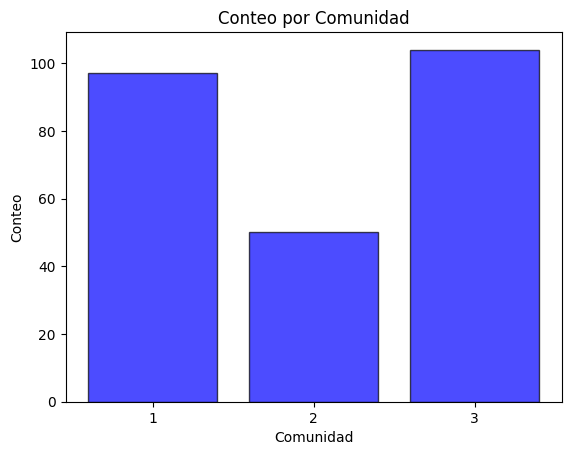

In [15]:
comunidades_lista = [ud.community for id, ud in uds_copy.items() if ud.activa]
histogram_communities(comunidades_lista)

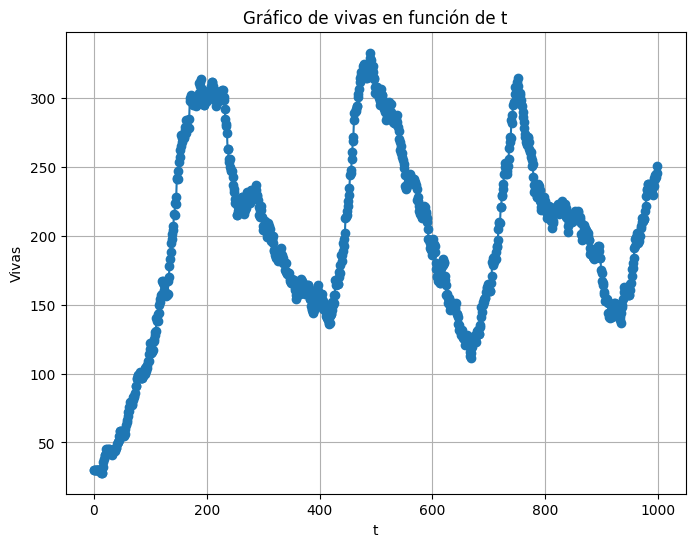

In [13]:
# Crear el gráfico
list_t = list(range(t))

plt.figure(figsize=(8, 6))
plt.plot(list_t, vivas, marker='o', linestyle='-')  # 'o' representa un marcador circular, '-' representa una línea sólida
plt.title('Gráfico de vivas en función de t')
plt.xlabel('t')
plt.ylabel('Vivas')
plt.grid(True)  # Agregar una cuadrícula al gráfico
plt.show()

In [12]:
comunidades_disponibles = [i for i in range(1, (int(50) // 10) + 1) for _ in range(10)]
comunidades_disponibles
(int(50) // 10)

5

In [15]:
def valores_circulares(numero):
    unidades_iniciales = int(numero)
    n = unidades_iniciales // 10

    if numero == 1:
        anterior = n
    else:
        anterior = numero - 1

    if numero == n:
        siguiente = 1
    else:
        siguiente = numero + 1

    return anterior, siguiente

# Ejemplo de uso
numero = 5
resultado_anterior, resultado_siguiente = valores_circulares(numero)
print("Número anterior circular:", resultado_anterior)
print("Número siguiente circular:", resultado_siguiente)

Número anterior circular: 4
Número siguiente circular: 6


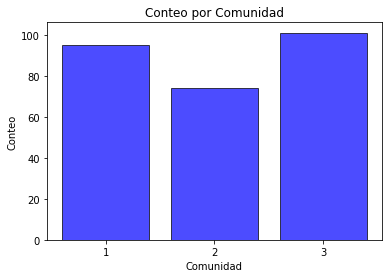

In [51]:
comunidades_lista = [ud.community for id, ud in uds_copy.items() if ud.activa]
histogram_communities(comunidades_lista)

In [6]:
def histogram_communities(comunidades_lista):
    # Utilizamos np.unique para obtener los valores únicos y sus frecuencias
    valores, conteos = np.unique(comunidades_lista, return_counts=True)

    # Creamos el gráfico de barras con transparencia ajustada
    plt.bar(valores, conteos, color='blue', edgecolor='black', alpha=0.7)

    # Añadimos etiquetas y título
    plt.title('Conteo por Comunidad')
    plt.xlabel('Comunidad')
    plt.ylabel('Conteo')

    # Establecemos los límites del eje x para que solo muestre números enteros
    plt.xticks(np.arange(min(valores), max(valores)+1, 1))

    # Mostramos el gráfico
    plt.show()

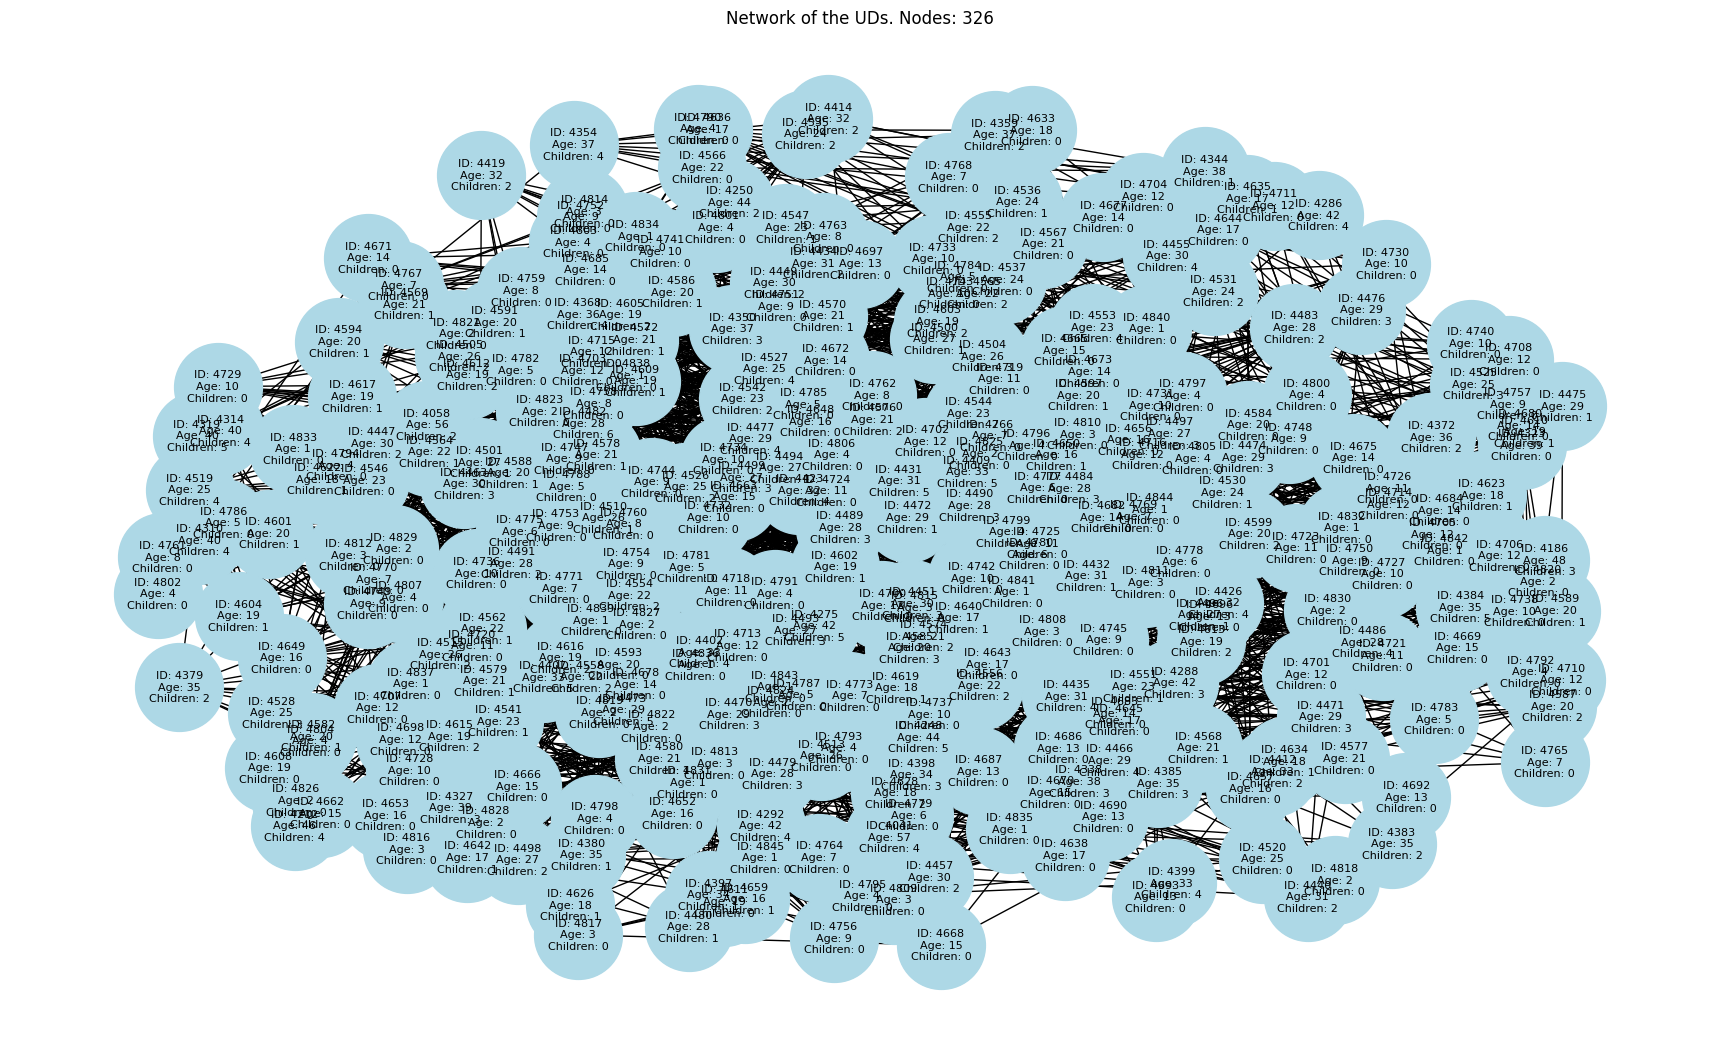

Betweenness Centrality:
{4702: 0.016104284729112125, 4431: 0.01558851547898685, 4586: 0.013421991333134022, 4747: 0.013059298826200553, 4605: 0.013030500886326887, 4472: 0.01226085450731905, 4714: 0.01218825512117615, 4827: 0.011854456850610314, 4494: 0.01182914515038063, 4763: 0.011217056232315833}

Closeness Centrality:
{4505: 0.4603399433427762, 4586: 0.45839210155148097, 4605: 0.45646067415730335, 4702: 0.45646067415730335, 4527: 0.4507628294036061, 4431: 0.45013850415512463, 4588: 0.45013850415512463, 4494: 0.44642857142857145, 4499: 0.4452054794520548, 4451: 0.44459644322845415}

Degree Centrality:
{4605: 0.11384615384615385, 4527: 0.1076923076923077, 4702: 0.1076923076923077, 4586: 0.10461538461538461, 4431: 0.09846153846153846, 4494: 0.09846153846153846, 4505: 0.09846153846153846, 4791: 0.09846153846153846, 4499: 0.09538461538461539, 4570: 0.09538461538461539}

Eigenvector Centrality:
{4527: 0.14172568545569367, 4605: 0.13538196858105772, 4570: 0.13188039688248462, 4499: 0.1298

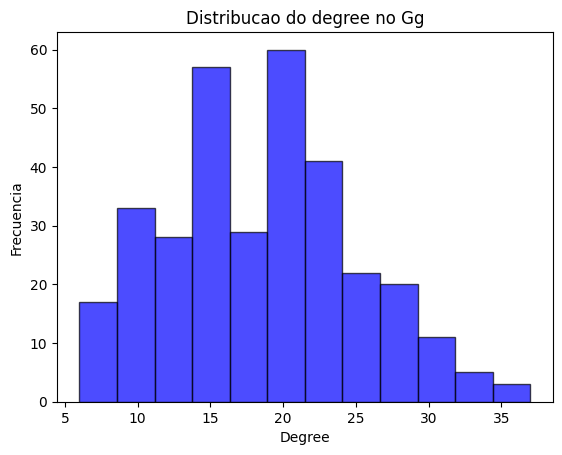

Densidade: 0.056875884851344975
Número de nós: 326
Número de aristas: 3013
Diámetro: 4
Transitividade: 0.38685381141740244
Average shorthest path: 2.5069561113732894
Coeficiente de Clustering Promedio (cluster maior): 0.40887801248195776
----------------------------


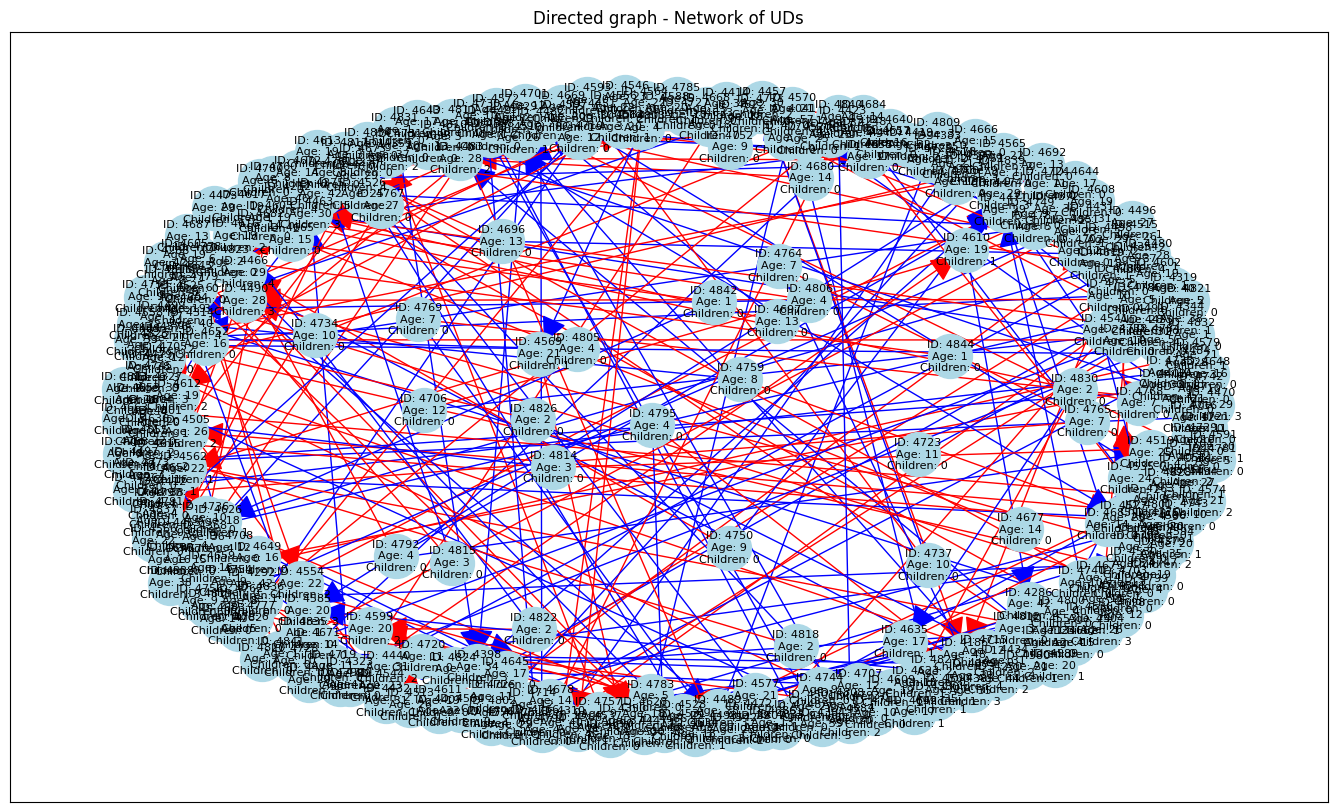

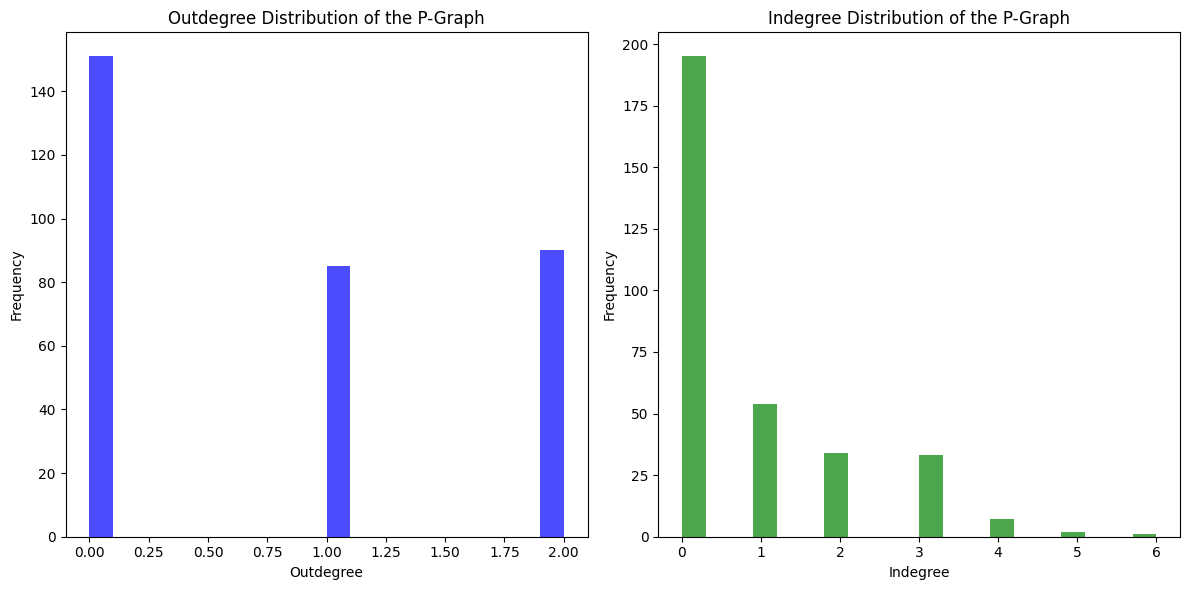

In [62]:
create_vis_geral(dict(UD.uds), True)
p_graph(dict(UD.uds), True)

In [38]:
dict(UD.uds)

{1: <__main__.UD at 0x242a595ab50>,
 2: <__main__.UD at 0x242a595aa00>,
 3: <__main__.UD at 0x242a595ae50>,
 4: <__main__.UD at 0x242a595a2b0>,
 5: <__main__.UD at 0x242a595a370>,
 6: <__main__.UD at 0x242a595a1c0>,
 7: <__main__.UD at 0x242a595a700>,
 8: <__main__.UD at 0x242a595adc0>,
 9: <__main__.UD at 0x242a595a3d0>,
 10: <__main__.UD at 0x242a595ab20>,
 11: <__main__.UD at 0x242a595ae80>,
 12: <__main__.UD at 0x242a5cd92e0>,
 13: <__main__.UD at 0x242a5cd9fd0>,
 14: <__main__.UD at 0x242a5cd95b0>,
 15: <__main__.UD at 0x242a5cd9400>,
 16: <__main__.UD at 0x242a5cd9790>,
 17: <__main__.UD at 0x242a5cd9eb0>,
 18: <__main__.UD at 0x242a5cd9370>,
 19: <__main__.UD at 0x242a5cd9cd0>,
 20: <__main__.UD at 0x242a5cd9280>,
 21: <__main__.UD at 0x242a5cd9c10>,
 22: <__main__.UD at 0x242a5cd9d90>,
 23: <__main__.UD at 0x242a5cd98e0>,
 24: <__main__.UD at 0x242a5cd9430>,
 25: <__main__.UD at 0x242a5cd9520>,
 26: <__main__.UD at 0x242a5cd9100>,
 27: <__main__.UD at 0x242a5cd9b80>,
 28: <__ma

In [5]:
# Verificar la asignación de comunidades
for id, ud in UD.uds.items():
    print(f"UD {ud.id} - Community: {ud.community}")

UD 1 - Community: 1
UD 2 - Community: 1
UD 3 - Community: 1
UD 4 - Community: 1
UD 5 - Community: 1
UD 6 - Community: 1
UD 7 - Community: 2
UD 8 - Community: 2
UD 9 - Community: 2
UD 10 - Community: 2
UD 11 - Community: 2
UD 12 - Community: 2
UD 13 - Community: 3
UD 14 - Community: 3
UD 15 - Community: 3
UD 16 - Community: 3
UD 17 - Community: 3
UD 18 - Community: 3
UD 19 - Community: 4
UD 20 - Community: 4
UD 21 - Community: 4
UD 22 - Community: 4
UD 23 - Community: 4
UD 24 - Community: 4
UD 25 - Community: 5
UD 26 - Community: 5
UD 27 - Community: 5
UD 28 - Community: 5
UD 29 - Community: 5
UD 30 - Community: 5
UD 31 - Community: 4
UD 32 - Community: 4
UD 33 - Community: 2
UD 34 - Community: 1
UD 35 - Community: 3
UD 36 - Community: 2
UD 37 - Community: 4
UD 38 - Community: 5
UD 39 - Community: 1
UD 40 - Community: 2
UD 41 - Community: 3
UD 42 - Community: 4
UD 43 - Community: 4
UD 44 - Community: 4
UD 45 - Community: 3
UD 46 - Community: 2
UD 47 - Community: 4
UD 48 - Community: 3
U

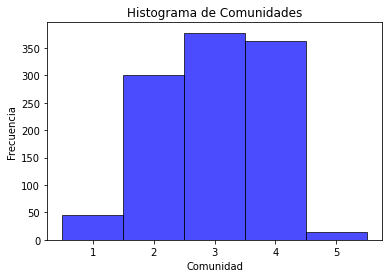

In [6]:
comunidades_lista = [ud.community for ud in UD.uds.values()]
# Crear un histograma
plt.hist(comunidades_lista, bins=range(1, 7), align='left', alpha=0.7, color='blue', edgecolor='black')

# Configurar el título y las etiquetas de los ejes
plt.title('Histograma de Comunidades')
plt.xlabel('Comunidad')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [ ]:
#Unidades
print(len(UD.uds))

# for id, nodo in UD.uds.items():
#     #print(nodo.id)
#     print(f"""
#     ID : {nodo.id},  
#     Estado = {nodo.activa}
#     Pai: {nodo.parentes[0]},    
#     Mãe: {nodo.parentes[1]}
#     Filhos (nós): {nodo.parentes[2]},    
#     Avos: {nodo.parentes[3]},    
#     Irmãos:{nodo.parentes[4]}
#     Tios:{nodo.parentes[5]},    
#     Primos: {nodo.parentes[6]},    
#     Netos: {nodo.parentes[7]}
#     Sobrinhos: {nodo.parentes[8]}
#     Filhos disponiveis: {nodo.filhos}
#     Cassais pasados: {nodo.parentes[9]}
#     Idade: {nodo.age}
#     """)

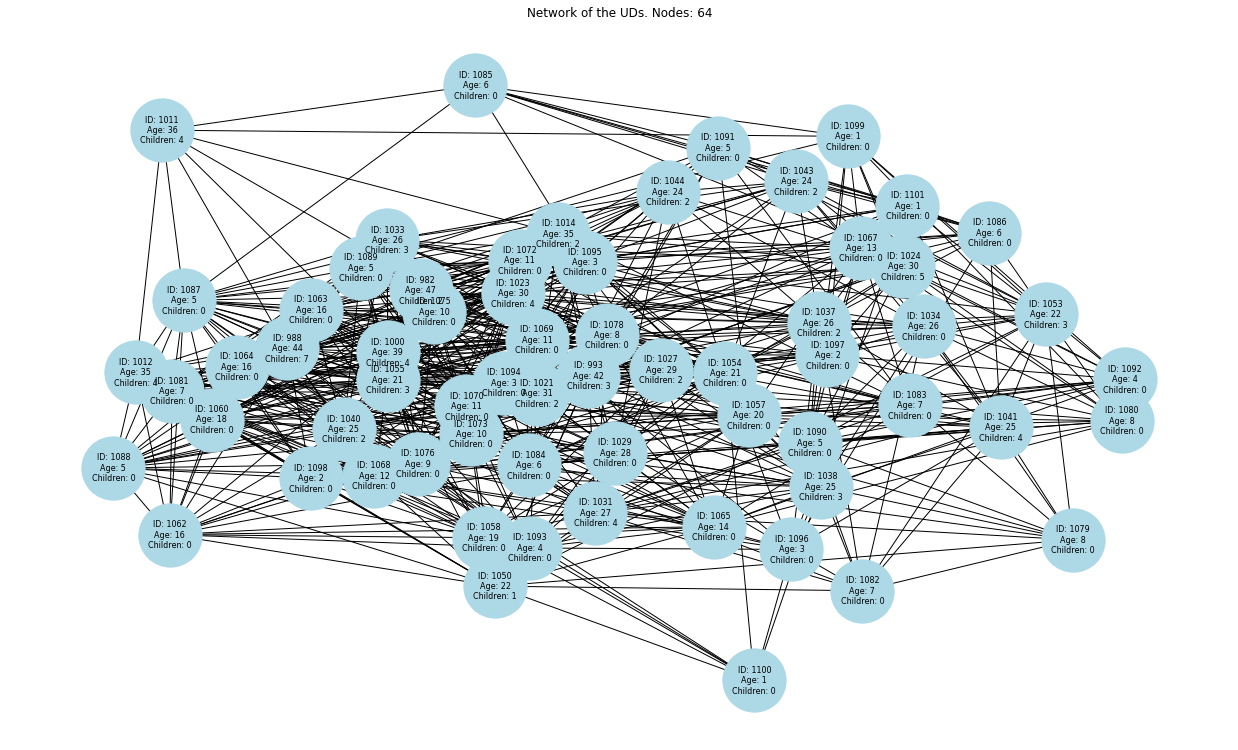

----------------------------


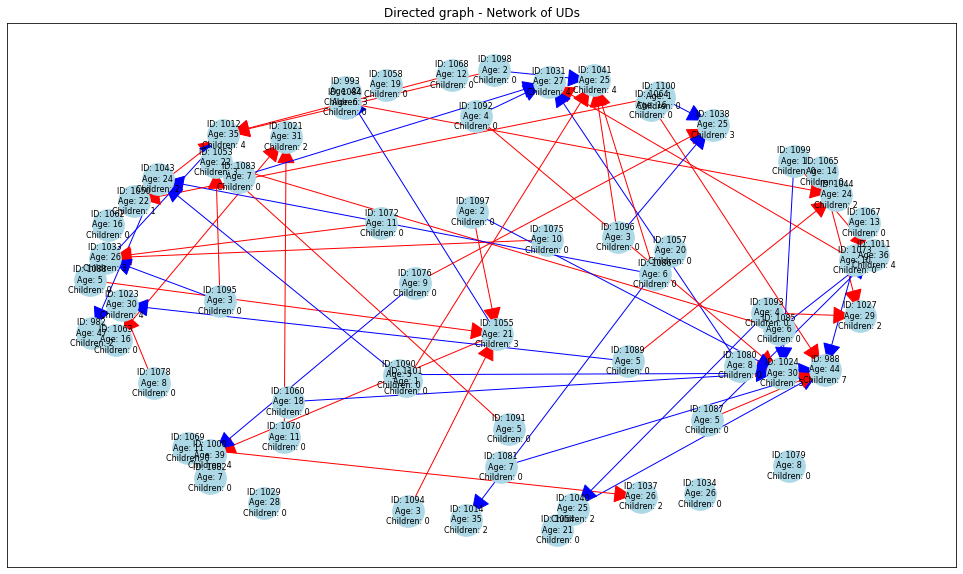

In [7]:
create_vis_geral(UD.uds, False)
p_graph(UD.uds, False)

# Experimento

In [15]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 5

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()

for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                uds_copy = dict(UD.uds)
                any_ud_active = False
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
                if not any_ud_active:
                    # Only 0
                    #print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
#folder_name = 'resultados_parametros_locality'
#if not os.path.exists(folder_name):
#    os.makedirs(folder_name)
# Heatmap and std
#heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_locality.npy')
#np.save(heat_std, mM)
# Behavior of experiments
#behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_locality.npy')
#np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)

The total time of the configuration of mean 1.0 and initial UDs 10.0 is  0.27887773513793945
        

The total time of the configuration of mean 1.0 and initial UDs 20.0 is  0.5863204002380371
        

The total time of the configuration of mean 1.0 and initial UDs 30.0 is  0.45778441429138184
        

The total time of the configuration of mean 1.0 and initial UDs 40.0 is  0.6168422698974609
        

The total time of the configuration of mean 1.0 and initial UDs 50.0 is  1.23870849609375
        

The total time of the configuration of mean 2.0 and initial UDs 10.0 is  0.11450672149658203
        

The total time of the configuration of mean 2.0 and initial UDs 20.0 is  0.7740850448608398
        

The total time of the configuration of mean 2.0 and initial UDs 30.0 is  0.8120660781860352
        

The total time of the configuration of mean 2.0 and initial UDs 40.0 is  1.273606538772583
        

The total time of the configuration of mean 2.0 and initial UDs 50.0 is  2

In [12]:
## heatmap and mean
mM_datos = mM
## behavior for experiments
mM_behavior = datos_1

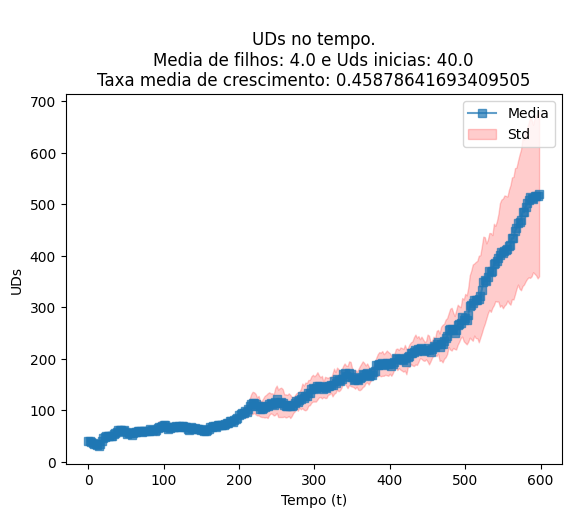

In [20]:
#Graph of experiment with mean and std
x = 3
y = 3

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

Text(0.5, 0, 'Unidades iniciais')

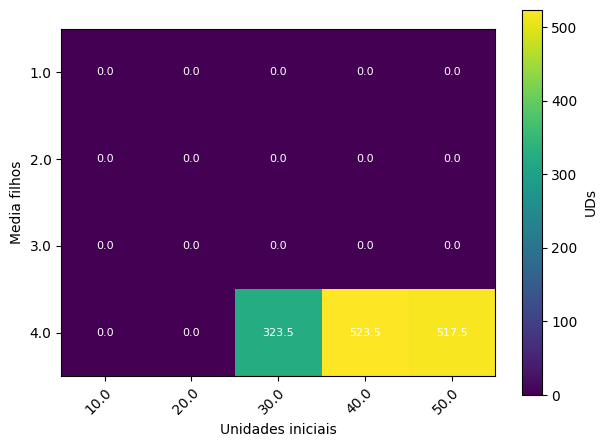

In [16]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

In [ ]:
##ORiginal with community
import numpy as np
import random
import math
## Class with rule of marriage of community: Only with different community
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self, id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear, locality): #metodo para buscar e reproducir.
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filho_disponivel, posição_filho, idade_filho = filho_e_idade(self, 0) #Se a unidade tem uma filha disponivel para procurar esposa
        if filho_disponivel:
            
            #Filtro para escolher outra UD para criar uma nova UD
            #Parentes disponivels: 
            uds_disponiveis = [id_ud for id_ud, ud in self.uds.items() if 
                    ud.activa == True and #Que a UD esteja viva.
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, self.parentes[0:5] + self.parentes[7:9]) and # Que a UD não seja um parent
                    filho_e_idade(ud,1)[0] and #Que tenha um filho
                    abs(filho_e_idade(ud,0)[2] - idade_filho) <= 13 and #Que a diferença entre as idades não seja maior a 10
                    ud.community != self.community] #From a different community 
            
            uds_disponiveis_sem_self_como_padre = [id_ud for id_ud in uds_disponiveis if 
                                    not is_id_in_nested_lists(self.id, self.uds[id_ud].parentes[0:5] + self.uds[id_ud].parentes[7:9])] #QUe a UD não seja um parente
            #Escolher uma UD da lista de uds_disponiveis_sem_self_como_padre e modificar
            if uds_disponiveis_sem_self_como_padre:
                cassal_id = random.choice(uds_disponiveis_sem_self_como_padre) #Cassal aleatorio da lista criada
                filha_disponivel, posição_filha, idade_filha = filho_e_idade(UD.uds[cassal_id], 1)
                #print(filha_disponivel, posição_filha, idade_filha)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filho)
                self.uds[cassal_id].filhos.pop(posição_filha)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
        if random.random() < 0.001:
            # uma aleatoria
            variedad_a_mutar = random.choice(vari_mae + vari_pai)
            # mutacao
            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

# Experiments when having the 